# Análisis de Sentimientos

Realizaremos un análisis de sentimientos simple sobre la columna `text` de los tweets para analizar tres cuestiones:

* Polaridad: Es un valor comprendido en el intervalo `[1, 1]` que indica qué tan negativo o positivo es un texto.
* Subjetividad: Es un valor comprendido en el intervalo `[0, 1]` que indica qué tan subjetivo u objetivo resulta el texto de un tweet.
* Sentimiento: Asignaremos un label positivo/negativo/neutral de acuerdo a la polaridad del texto.

Y ver si estas se relacionan con el target de los tweets.

Para esto utilizaremos dos herramientas:

* TextBlob: Será utilizada para obtener un puntaje de subjetividad.
* VADER: Será utilizada para obtener la polaridad del tweet y en base a este valor asignar los labels correspondientes.

Si bien TextBlob provee una forma de obtener un valor para la polaridad de un texto, luego de investigar sobre otras opciones nos topamos con VADER, que presenta muy buenos resultados a la hora de analizar contenido de redes sociales.

En particular nos interesó que pudiera tener en consideración cuestiones como el énfasis que agregan ciertos signos de puntuación (como `!`) así como también el uso de mayúsculas e incluso emojis!

Por lo tanto decidimos no quitar signos de puntuación, ni emojis, así como tampoco modificar mayúsculas/minúsculas ya que estos agregan valor al contexto del tweet.

Finalmente, el preprocesamiento del texto consistirá en remover:

* URLs.
* Menciones a usuarios: Los nombres de usuarios podrían generar ruido.
* El # precedente a un hashtag propiamente dicho.

Citamos a continuación el paper sobre el que está basado el módulo VADER:

> Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

# Preprocesamiento

In [1]:
import pandas as pd
pd.set_option('max_colwidth', -1)
import nltk
nltk.download('vader_lexicon')
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ndv/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('../dataset/train.csv', usecols=['text', 'target'], encoding='utf-8-sig')

In [3]:
# Quitamos las urls
df['text'] = df['text'].str.replace(r'http:\/\/.*', '', regex=True).replace(r'https:\/\/.*', '', regex=True)

# Quitamos user mentions y el símbolo del hashtag.
def clean_text(text):
    words = text.split(' ')
    text = ' '.join([word for word in words if not word.startswith('@')])
    text = text.replace('#', '')
    return text

df['text'] = df['text'].apply(clean_text)

In [4]:
# Este valor fue tomado del repositorio del módulo VADER.
POLARITY_TRESHOLD = 0.05

def obtain_sentiment(text):
    scores = analyzer.polarity_scores(text)
    
    sentiment = 'neu'
    if scores['compound'] >= POLARITY_TRESHOLD:
        sentiment = 'pos'
    if scores['compound'] <= -POLARITY_TRESHOLD:
        sentiment = 'neg'
    
    text_blob = TextBlob(text)
    subjectivity = text_blob.sentiment.subjectivity
    
    return sentiment, subjectivity, scores['compound']

df['sentiment'], df['subjectivity'], df['polarity'] = zip(*df['text'].apply(obtain_sentiment))
df.head()

,text,target,sentiment,subjectivity,polarity
0,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1,pos,0.0000,0.2732
1,Forest fire near La Ronge Sask. Canada,1,neg,0.4000,-0.3400
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,neg,0.3875,-0.2960
3,"13,000 people receive wildfires evacuation orders in California",1,neu,0.0000,0.0000
4,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1,neu,0.0000,0.0000


# Análisis

Finalmente obtuvimos valores para la subjetividad, polaridad y una clasificación del sentimiento asociado al tweet.
En esta seacción analizaremos cada una de estas variables respecto al target asociado al tweet.

### Polaridad

En primer lugar exploremos la polaridad de los tweets y la clasificación del sentimiento de cada uno, en particular nos interesa ver la distribución por clase de la polaridad.

Veamos cómo se distribuye la polaridad sobre el total de los tweets.

In [5]:
df['polarity'].describe()

count    7613.000000
mean    -0.144799   
std      0.454943   
min     -0.988300   
25%     -0.539900   
50%      0.000000   
75%      0.025800   
max      0.973000   
Name: polarity, dtype: float64

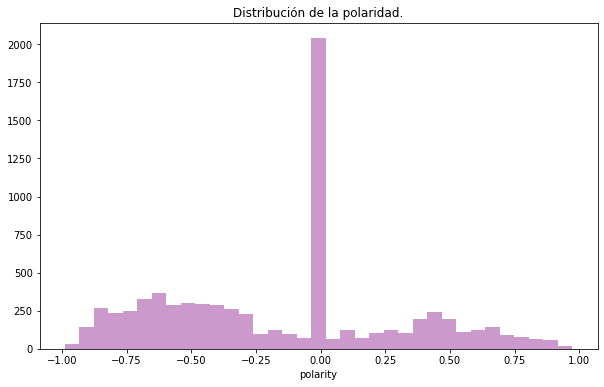

In [6]:
plt.figure(figsize=(10,6))
ax = sns.distplot(df['polarity'], kde=False, color='purple')
plt.title("Distribución de la polaridad.")
plt.show()

Notamos que hay una gran cantidad de tweets que toman un valor de polaridad cercano a 0. 

De todos modos esto no implica que la mayoría de los tweets sean de connotación neutral, ya que decidimos considerar como neutrales sólo a aquellos que tengan un valor de polaridad perteneciente al intervalo (-0.05, 0.05).

De hecho, lo que observamos es que pareciera ser que la mayor parte de los tweets tienen una polaridad negativa.

Ahora sí veamos la distribución de la polaridad en relación al target. 

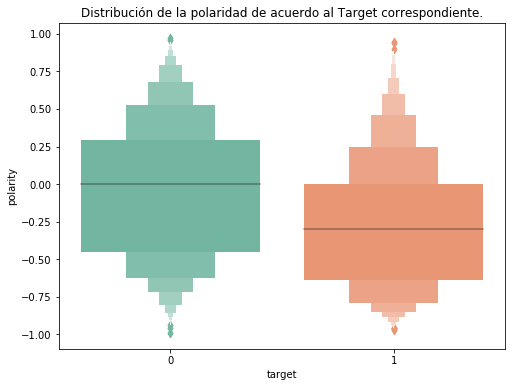

In [7]:
plt.figure(figsize=(8,6))
ax = sns.boxenplot(data=df, x='target', y='polarity', palette='Set2')
plt.title("Distribución de la polaridad de acuerdo al Target correspondiente.", )
plt.show()

Nos hemos topado con algunos resultados interesantes:

* La media de los tweets Reales (target == 1) es apenas menor a -0.25 mientras que para los tweets Falsos vale 0.
* En ambos casos se observa que la polaridad suele ser negativa.
* En particular, notamos a simple vista que los tweets Reales presentan una polaridad más negativa que los tweets Falsos.

Este último item podría ser útil a la hora de entrenar un modelo para clasificar tweets posteriormente.

### Subjetividad

Ahora realicemos un análisis similar para la subjetividad de los tweets.

In [8]:
df['subjectivity'].describe()

count    7613.000000
mean     0.295954   
std      0.327170   
min      0.000000   
25%      0.000000   
50%      0.200000   
75%      0.533333   
max      1.000000   
Name: subjectivity, dtype: float64

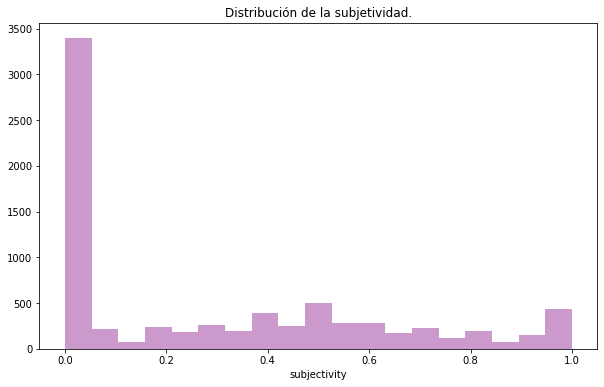

In [9]:
plt.figure(figsize=(10,6))
ax = sns.distplot(df['subjectivity'], kde=False, color='purple')
plt.title("Distribución de la subjetividad.")
plt.show()

En este caso notamos que una gran parte de los tweets parece tener una baja subjetividad.

Veamos ahora la distribución de la misma según el target.

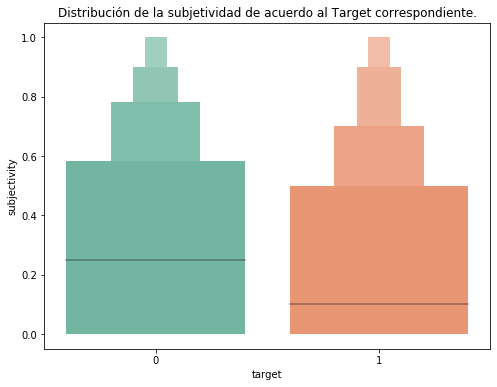

In [10]:
plt.figure(figsize=(8,6))
ax = sns.boxenplot(data=df, x='target', y='subjectivity', palette='Set2')
plt.title("Distribución de la subjetividad de acuerdo al Target correspondiente.", )
plt.show()

De esta visualización podemos notar que:

* Las medias nuevamente difieren, en el caso de los tweets Reales esta es menor.
* El 75% de los tweets Reales está por debajo del valor 0.5.
* El 75% de los tweets Falsos esta por debajo del valor 0.6.

Concluímos que la mayor parte de los tweets, independientemente de su clase, son poco _subjetivos_. Por lo tanto no creemos que esta variable pueda ser útil para la clasificación de tweets.

### Sentimiento

Finalmente veamos cómo han quedado asignados los labels relacionados al sentimiento de los tweets.

Recordemos que estos son:

* Positivo: si la polaridad >= 0.05.
* Negativo: si la polaridad es <= a -0.05.
* Neutral: si la polaridad está entre -0.05 y 0.05.

In [11]:
df['sentiment'].value_counts(normalize=True)

neg    0.479968
neu    0.272297
pos    0.247734
Name: sentiment, dtype: float64

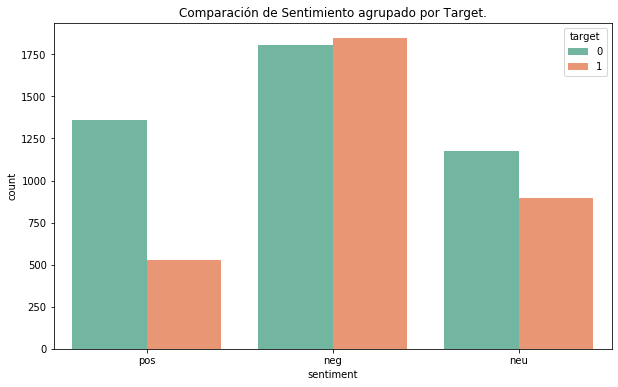

In [12]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df, x='sentiment', hue='target', palette="Set2")
plt.title('Comparación de Sentimiento agrupado por Target.')
plt.show()

A partir de esta visualización, observamos que:

* Los tweets clasificados como Negativos son mayoría, como observamos anteriormente en el análisis sobre la polaridad de los tweets.
* La cantidad de tweets Negativos es pareja entre las clases.
* La cantidad de tweets Positivos presenta una amplia brecha entre las clases. Esto fue observado anteriormente en el estudio de la polaridad, donde notamos que los tweets Reales tendían a ser más negativos que los Falsos.